In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import os
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

os.environ['CUDA_VISIBLE_DEVICES']='-1'

In [7]:
import sys
sys.path.append('../utils/')
from utils.DataVisualization import DataVisualization

# Modelo

## DataFrame:

In [8]:
path = r'../../data/customers/CASTING_DB063.csv'
df = pd.read_csv(
    filepath_or_buffer=path,
    parse_dates=['VUF_DT'],
    usecols=['VUF_DT', 'VUF_VLRLIQFINAL']
)

In [9]:
df.head(3)

,VUF_DT,VUF_VLRLIQFINAL
0,2022-05-22,189.99
1,2022-05-22,119.99
2,2022-05-22,99.99


## Código:

In [10]:
class Casting(DataVisualization):
    def gera_dataset(self, dataset, tamanho_janela=1):
        dataA, dataB = [], []
        for i in range(len(dataset)-tamanho_janela): # lembre-se que os datasets têm índices começando em zero
            a = dataset[i:(i+tamanho_janela)]['VUF_VLRLIQFINAL'].values #armazena todos os dados localizados da linha i até i + tamanho_janela
            dataA.append(a)
            dataB.append(dataset.loc[[i+tamanho_janela]]['VUF_VLRLIQFINAL'].values) #armazena apenas o dado localizado na linha i + tamanho_janela (esse não foi pego por dataA).
        return np.asarray(dataA, dtype=np.float32), np.asarray(dataB, dtype=np.float32)

if __name__ == '__main__':
    casting = Casting()

## Preparação Dos Dados:

### Selecionando as Variáveis:

In [11]:
dataset = df[['VUF_DT', 'VUF_VLRLIQFINAL']]

### Agrupando por mês:

In [12]:
dataset = (
    dataset.groupby(
        (dataset['VUF_DT']).dt.to_period("M")
    )['VUF_VLRLIQFINAL'].sum()
)

### Transformando em um dataframe:

In [13]:
dataset = dataset.to_frame()
dataset.reset_index(inplace=True)

### Convertendo para datetime:

In [14]:
dataset['VUF_DT'] = dataset['VUF_DT'].dt.to_timestamp()

### Removendo o mês de outubro:

In [15]:
dataset = dataset.drop(dataset.index[-1])
dataset = dataset.drop(dataset.index[0])

In [16]:
dataset

,VUF_DT,VUF_VLRLIQFINAL
1,2022-02-01,10980198.36
2,2022-03-01,13205997.56
3,2022-04-01,16111945.79
4,2022-05-01,22810386.07
5,2022-06-01,20468268.66
6,2022-07-01,15679438.79
7,2022-08-01,16309237.28
8,2022-09-01,15128928.49
9,2022-10-01,17460713.27
10,2022-11-01,16600863.66


In [17]:
dataset.describe()

,VUF_DT,VUF_VLRLIQFINAL
count,20,2.000000e+01
mean,2022-11-15 12:00:00,1.732600e+07
min,2022-02-01 00:00:00,1.098020e+07
25%,2022-06-23 12:00:00,1.486757e+07
50%,2022-11-16 00:00:00,1.612140e+07
75%,2023-04-08 12:00:00,1.785146e+07
max,2023-09-01 00:00:00,4.196574e+07
std,NaN,6.528174e+06


## Visualização Dos Dados:

### Gráfico de linha:

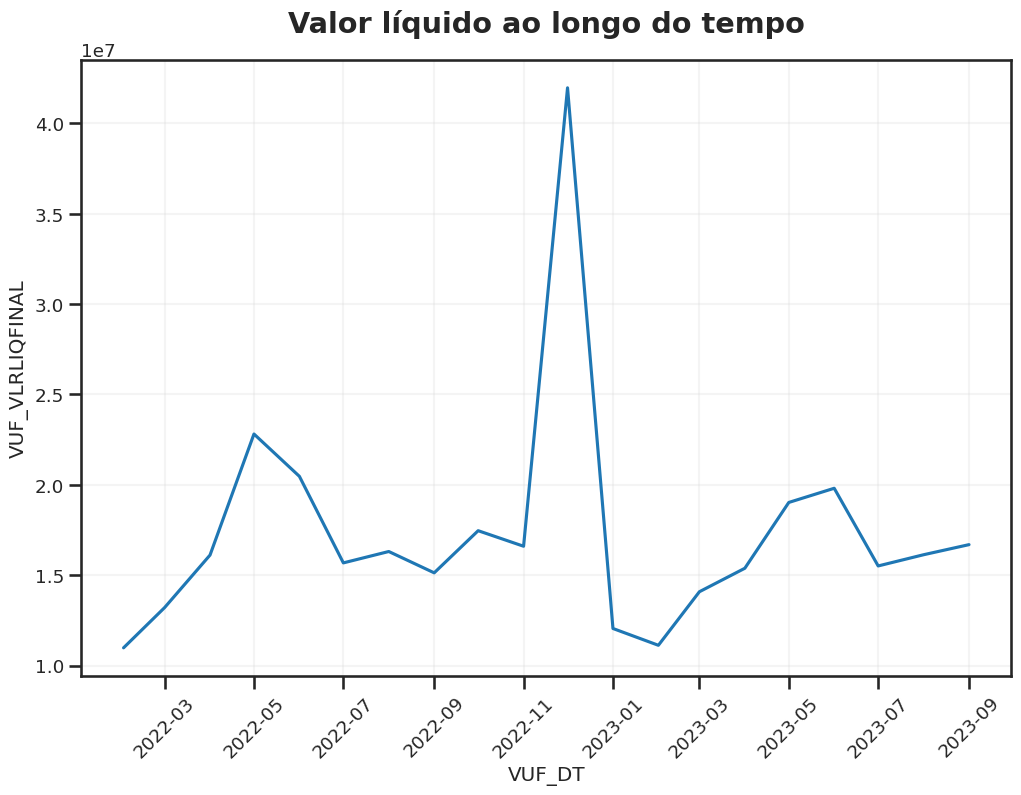

In [18]:
casting.gráfico_lineplot(
  dataframe=dataset,
  x='VUF_DT',
  y='VUF_VLRLIQFINAL',
  titulo='Valor líquido ao longo do tempo'
)

## Modelo:

### Normalizando Os Dados:

In [19]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset['VUF_VLRLIQFINAL'] = scaler.fit_transform(dataset['VUF_VLRLIQFINAL'].values.reshape(-1,1))

In [20]:
dataset.describe()

,VUF_DT,VUF_VLRLIQFINAL
count,20,20.000000
mean,2022-11-15 12:00:00,0.204799
min,2022-02-01 00:00:00,0.000000
25%,2022-06-23 12:00:00,0.125457
50%,2022-11-16 00:00:00,0.165923
75%,2023-04-08 12:00:00,0.221757
max,2023-09-01 00:00:00,1.000000
std,NaN,0.210684


### Separando Treino e Teste:

In [21]:
tamanho_treino = int(len(dataset) * 0.69)
treino, teste = dataset[0:tamanho_treino], dataset[tamanho_treino:len(dataset)]
teste = teste.reset_index(drop=True)

### Separando X e Y de Treino e Teste:

In [22]:
tamanho_janela=1
x_treino, y_treino = casting.gera_dataset(treino, tamanho_janela=tamanho_janela)
x_teste, y_teste = casting.gera_dataset(teste, tamanho_janela=tamanho_janela)

### [n_amostras, n_timesteps, n_features]:

In [23]:
x_treino = np.reshape(x_treino, (x_treino.shape[0], x_treino.shape[1], 1))
x_teste = np.reshape(x_teste, (x_teste.shape[0], x_treino.shape[1], 1))

### Verificando Shape:

In [24]:
print(x_treino.shape)
print(x_teste.shape)

(12, 1, 1)
(6, 1, 1)


In [25]:
# Empilhando LSTMs com stateful = True:

modelo = Sequential()
modelo.add(LSTM(8, batch_input_shape = (2, x_treino.shape[1], x_treino.shape[2]), stateful=True))

modelo.add(Dense(1)) # Saída da LSTM
modelo.compile(loss = 'mean_squared_error', optimizer = 'adam')
modelo.fit(x=x_treino, y=y_treino, epochs = 400, batch_size = 2, shuffle = False, verbose = 2)

Epoch 1/400
6/6 - 2s - loss: 0.1341 - 2s/epoch - 262ms/step
Epoch 2/400
6/6 - 0s - loss: 0.1288 - 15ms/epoch - 2ms/step
Epoch 3/400
6/6 - 0s - loss: 0.1169 - 15ms/epoch - 2ms/step
Epoch 4/400
6/6 - 0s - loss: 0.1054 - 16ms/epoch - 3ms/step
Epoch 5/400
6/6 - 0s - loss: 0.0955 - 13ms/epoch - 2ms/step
Epoch 6/400
6/6 - 0s - loss: 0.0872 - 12ms/epoch - 2ms/step
Epoch 7/400
6/6 - 0s - loss: 0.0804 - 15ms/epoch - 3ms/step
Epoch 8/400
6/6 - 0s - loss: 0.0749 - 13ms/epoch - 2ms/step
Epoch 9/400
6/6 - 0s - loss: 0.0705 - 13ms/epoch - 2ms/step
Epoch 10/400
6/6 - 0s - loss: 0.0673 - 8ms/epoch - 1ms/step
Epoch 11/400
6/6 - 0s - loss: 0.0651 - 10ms/epoch - 2ms/step
Epoch 12/400
6/6 - 0s - loss: 0.0636 - 10ms/epoch - 2ms/step
Epoch 13/400
6/6 - 0s - loss: 0.0629 - 9ms/epoch - 2ms/step
Epoch 14/400
6/6 - 0s - loss: 0.0625 - 9ms/epoch - 1ms/step
Epoch 15/400
6/6 - 0s - loss: 0.0623 - 10ms/epoch - 2ms/step
Epoch 16/400
6/6 - 0s - loss: 0.0623 - 10ms/epoch - 2ms/step
Epoch 17/400
6/6 - 0s - loss: 0.0622

In [26]:
from sklearn.metrics import mean_squared_error

# Previsões
previsao_treino = modelo.predict(x_treino, batch_size=2)
previsao_teste = modelo.predict(x_teste, batch_size=2)

# Inverte as previsões por conta da normalização
previsao_treino = scaler.inverse_transform(previsao_treino)
y_treino = scaler.inverse_transform(y_treino)
previsao_teste = scaler.inverse_transform(previsao_teste)
y_teste = scaler.inverse_transform(y_teste)

# Calcula o RMSE
score_treino = math.sqrt(mean_squared_error(y_treino, previsao_treino))
print('Score em Treino: %.2f RMSE' % (score_treino))  
score_teste = math.sqrt(mean_squared_error(y_teste, previsao_teste))
print('Score em Teste: %.2f RMSE' % (score_teste))

3/3 [==============================] - 0s 2ms/step
Score em Treino: 189694.01 RMSE
Score em Teste: 2528065.00 RMSE


In [27]:
previsao_treino

array([[10910244.],
       [13192241.],
       [15893283.],
       [22519182.],
       [20590940.],
       [15510445.],
       [16475886.],
       [15048751.],
       [17753124.],
       [16446679.],
       [42020224.],
       [12372139.]], dtype=float32)